<a href="https://colab.research.google.com/github/superbunny38/MachineLearning/blob/main/CS229MachineLearning/2022AndrewLectureNotes/Probset2/Prob1/Set2Problem1(a)(b).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time

**Rights**:

*Assignment made by: Prof. Andrew Ng, Stanford*

 *Assignment solved by: Chaeeun Ryu, SKKU*

In [72]:
#@title Utils
import csv

import matplotlib.pyplot as plt
import numpy as np
import json


def add_intercept_fn(x):
    """Add intercept to matrix x.

    Args:
        x: 2D NumPy array.

    Returns:
        New matrix same as x with 1's in the 0th column.
    """
    new_x = np.zeros((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
    new_x[:, 0] = 1
    new_x[:, 1:] = x

    return new_x

def load_csv(csv_path, label_col='y', add_intercept=False):
    """Load dataset from a CSV file.

    Args:
         csv_path: Path to CSV file containing dataset.
         label_col: Name of column to use as labels (should be 'y' or 'l').
         add_intercept: Add an intercept entry to x-values.

    Returns:
        xs: Numpy array of x-values (inputs).
        ys: Numpy array of y-values (labels).
    """

    # Load headers
    with open(csv_path, 'r', newline='') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
    inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
    labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

    if inputs.ndim == 1:
        inputs = np.expand_dims(inputs, -1)

    if add_intercept:
        inputs = add_intercept_fn(inputs)

    return inputs, labels

def load_spam_dataset(tsv_path):
    """Load the spam dataset from a TSV file

    Args:
         csv_path: Path to TSV file containing dataset.

    Returns:
        messages: A list of string values containing the text of each message.
        labels: The binary labels (0 or 1) for each message. A 1 indicates spam.
    """

    messages = []
    labels = []

    with open(tsv_path, 'r', newline='', encoding='utf8') as tsv_file:
        reader = csv.reader(tsv_file, delimiter='\t')

        for label, message in reader:
            messages.append(message)
            labels.append(1 if label == 'spam' else 0)

    return messages, np.array(labels)

def plot(x, y, prev_theta, theta, save_path, correction=1.0):
    """Plot dataset and fitted logistic regression parameters.

    Args:
        x: Matrix of training examples, one per row.
        y: Vector of labels in {0, 1}.
        theta: Vector of parameters for logistic regression model.
        save_path: Path to save the plot.
        correction: Correction factor to apply (Problem 2(e) only).
    """
    # Plot dataset
    plt.figure()
    plt.plot(x[y == 1., -2], x[y == 1., -1], 'bx', linewidth=2)
    plt.plot(x[y == -1., -2], x[y == -1., -1], 'go', linewidth=2)

    # Plot decision boundary (found by solving for theta^T x = 0)
    x1 = np.arange(min(x[:, -2]), max(x[:, -2]), 0.01)
    x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)
    prev_x2 =  -(prev_theta[0] / prev_theta[2] * correction + prev_theta[1] / prev_theta[2] * x1)
    plt.plot(x1,prev_x2, c='gray',linewidth = 2, label = "prev theta")
    plt.plot(x1, x2, c='red', linewidth=2, label = "theta")
    
    plt.legend()

    # Add labels and save to disk
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.savefig(save_path)


def plot_contour(predict_fn):
    """Plot a contour given the provided prediction function"""
    x, y = np.meshgrid(np.linspace(-10, 10, num=20), np.linspace(-10, 10, num=20))
    z = np.zeros(x.shape)

    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            z[i, j] = predict_fn([x[i, j], y[i, j]])

    plt.contourf(x, y, z, levels=[-float('inf'), 0, float('inf')], colors=['orange', 'cyan'])

def plot_points(x, y):
    """Plot some points where x are the coordinates and y is the label"""
    x_one = x[y == 0, :]
    x_two = x[y == 1, :]
    
    plt.scatter(x_one[:,0], x_one[:,1], marker='x', color='red')
    plt.scatter(x_two[:,0], x_two[:,1], marker='o', color='blue')

def write_json(filename, value):
    """Write the provided value as JSON to the given filename"""
    with open(filename, 'w') as f:
        json.dump(value, f)

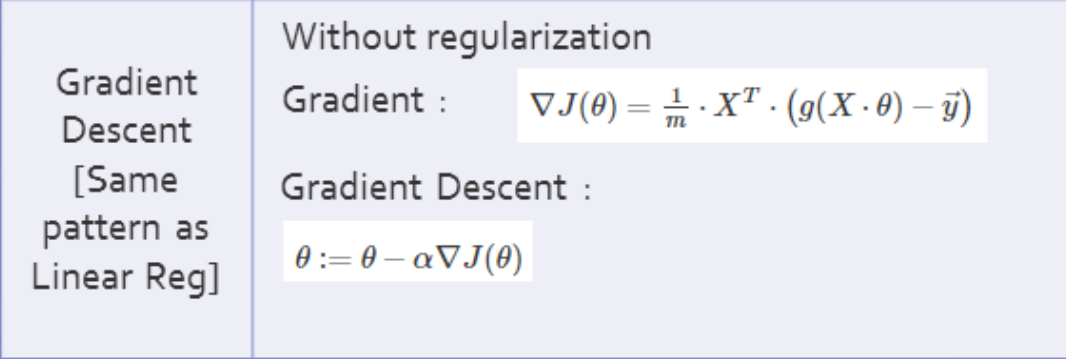

In [79]:
# Important note: you do not have to modify this file for your homework.
def calc_grad(X, Y, theta):
    """Compute the gradient of the loss with respect to theta."""
    m, n = X.shape
    margins = Y * X.dot(theta)
    probs = 1. / (1 + np.exp(margins))
    grad = -(1./m) * (X.T.dot(probs * Y))
    return grad


def get_probs(X, Y, theta):
  m,n = X.shape
  margins = Y*X.dot(theta)
  probs = 1. / (1+np.exp(margins))
  return probs


def logistic_regression(X, Y):
    """Train a logistic regression model."""
    m, n = X.shape
    theta = np.zeros(n)
    learning_rate = 10

    i = 0
    while True:
        i += 1
        prev_theta = theta
        grad = calc_grad(X, Y, theta)
        theta = theta - learning_rate * grad
        if i % 10000 == 0:
            print('Finished %d iterations' % i)
        if np.linalg.norm(prev_theta - theta) < 1e-15:
            print('Converged in %d iterations' % i)
            break
        if i % 50000 == 0:
            print("giving up converging")
            break
    return prev_theta, theta


def main():
    print('==== Training model on data set A ====')
    Xa, Ya = load_csv('/content/ds1_a.csv', add_intercept=True)
    prev_theta_a, theta_a = logistic_regression(Xa, Ya)

    print('\n==== Training model on data set B ====')
    Xb, Yb = load_csv('/content/ds1_b.csv', add_intercept=True)
    prev_theta_b, theta_b = logistic_regression(Xb, Yb)

    return prev_theta_a, theta_a, prev_theta_b, theta_b


if __name__ == '__main__':
    prev_theta_a, theta_a, prev_theta_b, theta_b = main()

==== Training model on data set A ====
Finished 10000 iterations
Finished 20000 iterations
Finished 30000 iterations
Converged in 30372 iterations

==== Training model on data set B ====
Finished 10000 iterations
Finished 20000 iterations
Finished 30000 iterations
Finished 40000 iterations
Finished 50000 iterations
giving up converging


# (a)
What is the most notable difference in training the logistic regression model on datasets A and B?

**Answer**:
Although for training dataset A, the model seemed to converge and ran comparatively less iterations (30372), on dataset B, the model doesn't converge and runs a lot of iterations. So for dataset B, I had to stop the model from running, because the code won't stop running.

# (b)
Investigate why the training procedure behaves unexpectedly on dataset B, but not on A. Provide hard evidence (in the form of math, code, plots, etc.) to corroborate your hypothesis for the misbehavior. Remember, you should address why your explanation does *not* apply to A.

### Check by plotting data

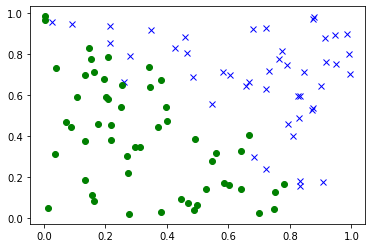

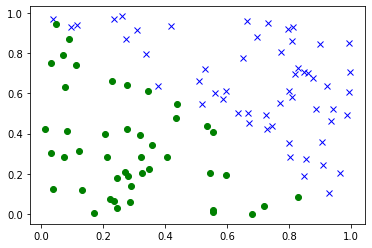

In [77]:
import numpy as np
import matplotlib.pyplot as plt
def plot(x,y):
    plt.figure()
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
    plt.plot(x[y == -1, -2], x[y == -1, -1], 'go', linewidth=2)
    plt.show()
Xa, Ya = load_csv('/content/ds1_a.csv', add_intercept=True)
Xb, Yb = load_csv('/content/ds1_b.csv', add_intercept=True)
plot(Xa,Ya)
plot(Xb,Yb)

In [4]:
data_a = pd.read_csv('/content/ds1_a.csv')
data_a.head()

,y,x0,x1
0,-1.0,0.601266,0.165091
1,1.0,0.871725,0.527361
2,-1.0,0.372548,0.446609
3,-1.0,0.013577,0.051358
4,1.0,0.583032,0.710619


In [5]:
theta_a

array([-20.81437788,  21.45295159,  19.85198176])

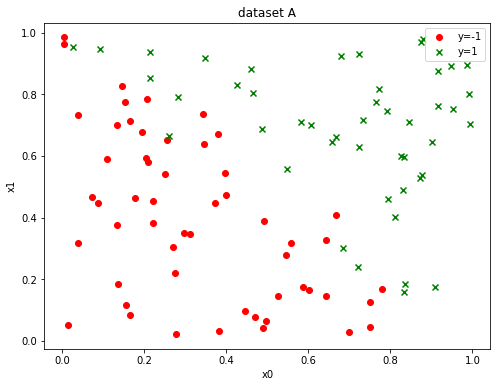

In [6]:
plt.figure(figsize = (8,6))
plt.title("dataset A")
plt.scatter(data_a[data_a['y'] == -1.0]['x0'],data_a[data_a['y'] == -1.0]['x1'], c = 'red',marker = 'o', label = "y=-1")
plt.scatter(data_a[data_a['y'] == 1.0]['x0'],data_a[data_a['y'] == 1.0]['x1'], c = 'green',marker = 'x', label = "y=1")
plt.legend()
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

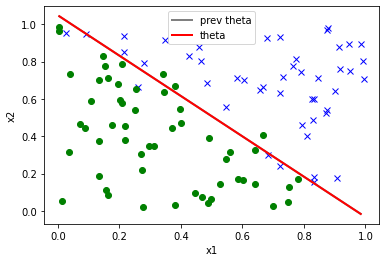

In [7]:
Xa, Ya = load_csv('/content/ds1_a.csv', add_intercept=True)
plot(Xa,Ya,prev_theta_a, theta_a,save_path = "/content/")

In [8]:
predictions_a = []
for x in Xa:
  predictions_a.append(x@theta_a)

In [9]:
preds_a = []
for p in predictions_a:
  if p < 0:
    preds_a.append(-1)
  else:
    preds_a.append(1)

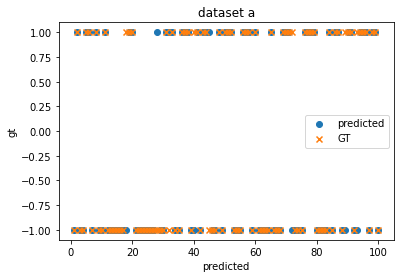

In [10]:
plt.title("dataset a")
plt.scatter(np.arange(1,len(Ya)+1,1), preds_a, label ="predicted")
plt.scatter(np.arange(1,len(Ya)+1,1),Ya, marker = 'x', label ="GT")
plt.legend()
plt.xlabel("predicted")
plt.ylabel("gt")
plt.show()

In [11]:
np.array_equal(Ya,preds_a)

False

In [12]:
mse = 0
for pred, y in zip(predictions_a, Ya):
  mse += (pred-y)**2
mse = mse/len(predictions_a)
print(mse)

60.70146488056387


In [13]:
data_b = pd.read_csv('/content/ds1_b.csv')
data_b.head()

,y,x0,x1
0,-1.0,0.595663,0.193072
1,-1.0,0.436997,0.544807
2,1.0,0.899945,0.845922
3,-1.0,0.555064,0.009263
4,-1.0,0.074687,0.282845


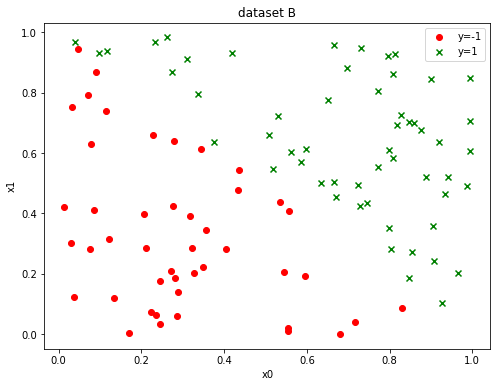

In [14]:
plt.figure(figsize = (8,6))
plt.title("dataset B")
plt.scatter(data_b[data_b['y'] == -1.0]['x0'],data_b[data_b['y'] == -1.0]['x1'], c = 'red',marker = 'o', label = "y=-1")
plt.scatter(data_b[data_b['y'] == 1.0]['x0'],data_b[data_b['y'] == 1.0]['x1'], c = 'green',marker = 'x', label = "y=1")
plt.legend()
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

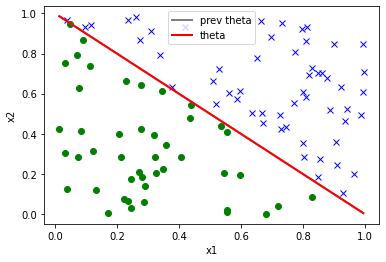

In [15]:
Xb, Yb = load_csv('/content/ds1_b.csv', add_intercept=True)
plot(Xb,Yb,prev_theta_b, theta_b,save_path = "/content/")

In [16]:
predictions_b = []
for x in Xb:
  predictions_b.append(x@theta_b)

In [17]:
preds_b = []
for p in predictions_b:
  if p < 0:
    preds_b.append(-1)
  else:
    preds_b.append(1)

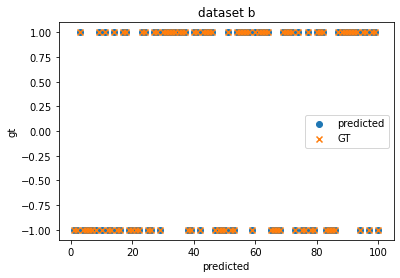

In [18]:
plt.title("dataset b")
plt.scatter(np.arange(1,len(Yb)+1,1), preds_b, label ="predicted")
plt.scatter(np.arange(1,len(Yb)+1,1),Yb, marker = 'x', label ="GT")
plt.legend()
plt.xlabel("predicted")
plt.ylabel("gt")
plt.show()

In [19]:
np.array_equal(Yb,preds_b)

True

In [20]:
mse = 0
for pred, y in zip(predictions_b, Yb):
  mse += (pred-y)**2
mse = mse/len(predictions_b)
print(mse)

1582.2558019783587


In [21]:
print(f"previous theta for dataset b: {prev_theta_b} final theta for dataset b:{theta_b}")

previous theta for dataset b: [-95.01770902  95.1941405   95.05451311] final theta for dataset b:[-95.01838735  95.1948202   95.0551918 ]


In [22]:
print(f"previous theta for dataset a: {prev_theta_a} final theta for dataset a:{theta_a}")

previous theta for dataset a: [-20.81437788  21.45295159  19.85198176] final theta for dataset a:[-20.81437788  21.45295159  19.85198176]


In [23]:
print(f"norm for theta a:{np.linalg.norm(prev_theta_a - theta_a)}")

norm for theta a:0.0


In [24]:
print(f"norm for theta b:{np.linalg.norm(prev_theta_b - theta_b)}")

norm for theta b:0.0011758957242939641


### Check for learning rate

In [33]:
def logistic_regression(X, Y, new_lr):
    """Train a logistic regression model."""
    m, n = X.shape
    theta = theta_b
    learning_rate = new_lr#10->new_lr

    i = 0
    while True:
        i += 1
        prev_theta = theta
        grad = calc_grad(X, Y, theta)
        theta = theta - learning_rate * grad
        if i % 20000 == 0:
            print('Finished %d iterations' % i)
        if np.linalg.norm(prev_theta - theta) < 1e-15:
            print('Converged in %d iterations' % i)
            break
        if i % 60000 == 0:
            print("giving up converging")
            break
    return prev_theta, theta

In [35]:
lrs = [0.001,0.01, 0.1,0.3,0.5,1,3]
for i in lrs:
  print(f"\nlearning rate: {i}")
  logistic_regression(Xb, Yb,i)


learning rate: 0.001
Finished 20000 iterations
Finished 40000 iterations
Finished 60000 iterations
giving up converging

learning rate: 0.01
Finished 20000 iterations
Finished 40000 iterations
Finished 60000 iterations
giving up converging

learning rate: 0.1
Finished 20000 iterations
Finished 40000 iterations
Finished 60000 iterations
giving up converging

learning rate: 0.3
Finished 20000 iterations
Finished 40000 iterations
Finished 60000 iterations
giving up converging

learning rate: 0.5
Finished 20000 iterations
Finished 40000 iterations
Finished 60000 iterations
giving up converging

learning rate: 1
Finished 20000 iterations
Finished 40000 iterations
Finished 60000 iterations
giving up converging

learning rate: 3
Finished 20000 iterations
Finished 40000 iterations
Finished 60000 iterations
giving up converging


### Check Gradient Calculation

In [59]:
def logistic_regression(X, Y, new_lr, theta = theta):#leveraged weights from previous iterations
    """Train a logistic regression model."""
    m, n = X.shape
    theta = theta
    learning_rate = new_lr#10->new_lr

    i = 0
    while True:
        i += 1
        prev_theta = theta
        grad = calc_grad(X, Y, theta)
        
        theta = theta - learning_rate * grad
        if i % 200000 == 0:
            print(f"grad: {grad}")
            print('Finished %d iterations' % i)
        if np.linalg.norm(prev_theta - theta) < 1e-15:
            print('Converged in %d iterations' % i)
            break
        if i % 6000000 == 0:
            print("giving up converging")
            break
    return prev_theta, theta

In [67]:
prev_theta, theta = logistic_regression(Xb,Yb,10000, theta)#may be learning rate was too small?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


grad: [-8.27958319e-17 -3.31510138e-18 -8.01202409e-17]
Finished 200000 iterations
grad: [-8.27958022e-17 -3.31510019e-18 -8.01202122e-17]
Finished 400000 iterations
grad: [-8.27957726e-17 -3.31509900e-18 -8.01201835e-17]
Finished 600000 iterations
grad: [-8.27957429e-17 -3.31509782e-18 -8.01201549e-17]
Finished 800000 iterations
grad: [-8.27957133e-17 -3.31509663e-18 -8.01201262e-17]
Finished 1000000 iterations
grad: [-8.27956837e-17 -3.31509544e-18 -8.01200975e-17]
Finished 1200000 iterations
grad: [-8.27956540e-17 -3.31509426e-18 -8.01200688e-17]
Finished 1400000 iterations
grad: [-8.27956244e-17 -3.31509307e-18 -8.01200402e-17]
Finished 1600000 iterations
grad: [-8.27955948e-17 -3.31509188e-18 -8.01200115e-17]
Finished 1800000 iterations
grad: [-8.27955651e-17 -3.31509070e-18 -8.01199828e-17]
Finished 2000000 iterations
grad: [-8.27955355e-17 -3.31508951e-18 -8.01199541e-17]
Finished 2200000 iterations
grad: [-8.27955059e-17 -3.31508832e-18 -8.01199254e-17]
Finished 2400000 iterati

In [69]:
theta

array([-7512.83848336,  7443.24415601,  7489.25928031])

In [68]:
abs(-8.27955059e-17) < 1e-15

True

### Check Probability

In [102]:
def get_probs_plot(X, Y, theta, title = ""):
  m,n = X.shape
  margins = X.dot(theta)
  probs = 1. / (1+np.exp(-margins))
  plt.title(title)
  plt.scatter(margins, probs)
  plt.xlabel("z")
  plt.ylabel("g(z)")
  plt.show()
  return probs

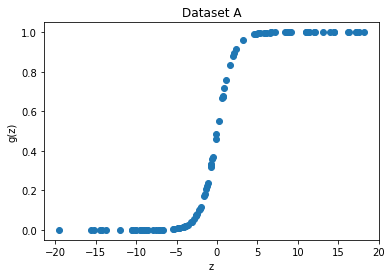

In [103]:
probs_a = get_probs_plot(Xa,Ya,theta_a, title = "Dataset A")

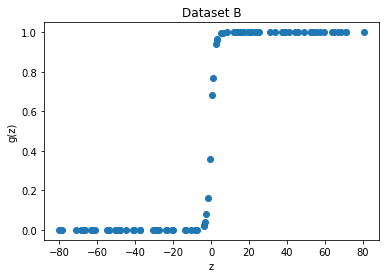

In [104]:
probs_b = get_probs_plot(Xb,Yb,theta_b, title = "Dataset B")

### Check Margins

In [105]:
def calc_grad(X, Y, theta):
    """Compute the gradient of the loss with respect to theta."""
    m, n = X.shape
    margins = Y * X.dot(theta)
    probs = 1. / (1 + np.exp(margins))
    grad = -(1./m) * (X.T.dot(probs * Y))
    return grad

In [110]:
margins_a = Ya*Xa.dot(theta_a)
probs_a = 1./(1+np.exp(margins_a))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


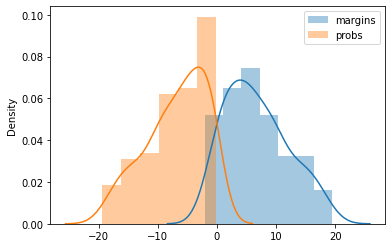

In [116]:
sns.distplot(margins_a, label = "margins")
sns.distplot(np.log(probs_a), label = "probs")
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


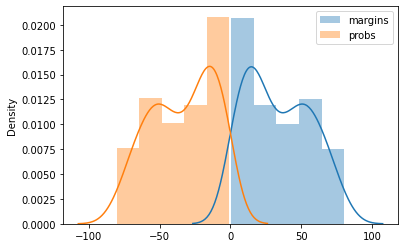

In [115]:
margins_b = Yb*Xb.dot(theta_b)
probs_b = 1./(1+np.exp(margins_b))
sns.distplot(margins_b, label = "margins")
sns.distplot(np.log(probs_b),label = "probs")
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


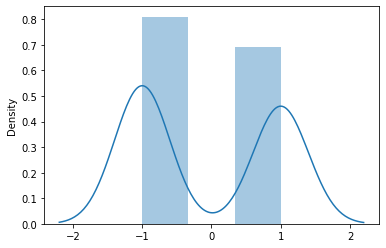

In [117]:
sns.distplot(Ya)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


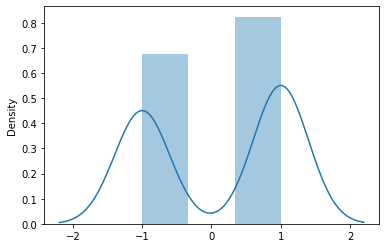

In [118]:
sns.distplot(Yb)